In [1]:
import sys,os
import json
import numpy as np
import matplotlib.pyplot as plt
from fcc_python_tools.locations import loc
from fcc_python_tools import plotting
import pandas as pd
from root_pandas import read_root, to_root
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report, roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.externals import joblib
from sklearn.utils.class_weight import compute_sample_weight
from scipy.stats import ks_2samp
import xgboost as xgb

from matplotlib import rc
rc('font',**{'family':'serif','serif':['Roman']})
rc('text', usetex=True)

Welcome to JupyROOT 6.20/06


/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.18.5 is currently installed but you installed root_numpy against numpy 1.16.4. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)
/cvmfs/sft.cern.ch/lcg/views/LCG_97apython3/x86_64-centos7-gcc8-opt/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [2]:
#Variables to use in the MVA
training_vars = ["EVT_thrutshemis_e_min",
                 "EVT_thrutshemis_e_max",
                 "echarged_min",
                 "echarged_max",
                 "eneutral_min",
                 "eneutral_max",
                 "ncharged_min",
                 "ncharged_max",
                 "nneutral_min",
                 "nneutral_max"
                ]

In [3]:
#Bc -> tau nu signal
path = f"{loc.OUT}/ROOT"
df_sig = read_root(f"{path}/Bc2TauNu.root","events",columns=training_vars)

In [4]:
#Z -> qq inclusive
n_tot_bkg = 1e6
BF = {}
BF["bb"] = 0.1512
BF["cc"] = 0.1203
BF["uds"] = 0.6991 - BF["bb"] - BF["cc"]
BF_tot = BF["uds"] + BF["cc"] + BF["bb"]
df_bkg = {}
for q in ["uds","cc","bb"]:
    df_bkg[q] = read_root(f"{path}/inclusive_Z{q}.root","events",columns=training_vars)
    print(f"Total size of {q} sample: {len(df_bkg[q])}")
    df_bkg[q] = df_bkg[q].sample(n=int(n_tot_bkg*(BF[q]/BF_tot)),random_state=10)
    print(f"Size of {q} in combined sample: {len(df_bkg[q])}")
    

Total size of uds sample: 9980004
Size of uds in combined sample: 611643
Total size of cc sample: 4655078
Size of cc in combined sample: 172078
Total size of bb sample: 9882716
Size of bb in combined sample: 216278


In [5]:
#Make a combined background sample according to BFs
df_bkg_tot = df_bkg["uds"].append(df_bkg["cc"])
df_bkg_tot = df_bkg_tot.append(df_bkg["bb"])
#Shuffle the background so it is an even mixture of the modes
df_bkg_tot = df_bkg_tot.sample(frac=1)

In [6]:
#Signal and background labels
df_sig["label"] = 1
df_bkg_tot["label"] = 0

#Combine the datasets
df_tot = df_sig.append(df_bkg_tot)

In [7]:
#Split into class label (y) and training vars (x)
y = df_tot["label"]
x = df_tot[training_vars]

In [8]:
#Split into samples to be used in the two BDTs, which will be used to make predictions for each other
x_A, x_B, y_A, y_B = train_test_split(x, y, test_size=0.5, random_state=100)

In [9]:
#Sample weights to balance the classes
weights_A = compute_sample_weight(class_weight='balanced', y=y_A)
weights_B = compute_sample_weight(class_weight='balanced', y=y_B)

In [10]:
#BDTs for each sample, which we will apply to the other sample (cross BDT)
config_dict = {
        "n_estimators": 400,
        "learning_rate": 0.3,
        "max_depth": 3,
        }

bdt_A = xgb.XGBClassifier(n_estimators=config_dict["n_estimators"], 
                                   max_depth=config_dict["max_depth"], 
                                   learning_rate=config_dict["learning_rate"], 
                                  )

bdt_B = xgb.XGBClassifier(n_estimators=config_dict["n_estimators"], 
                                   max_depth=config_dict["max_depth"], 
                                   learning_rate=config_dict["learning_rate"], 
                                  )

In [11]:
#Fit the models
bdt_A.fit(x_A, y_A, sample_weight=weights_A)
bdt_B.fit(x_B, y_B, sample_weight=weights_B) 

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.3, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=400, n_jobs=1,
              nthread=None, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)

In [12]:
#Get the feature importances 
feature_importances_A = pd.DataFrame(bdt_A.feature_importances_,
                                     index = training_vars,
                                     columns=['importance']).sort_values('importance',ascending=False)

print("Feature importances for BDT A")
print(feature_importances_A)

feature_importances_B = pd.DataFrame(bdt_B.feature_importances_,
                                     index = training_vars,
                                     columns=['importance']).sort_values('importance',ascending=False)

print("Feature importances for BDT B")
print(feature_importances_B)

Feature importances for BDT A
                       importance
EVT_thrutshemis_e_min    0.608349
eneutral_min             0.111191
echarged_min             0.097065
EVT_thrutshemis_e_max    0.071433
eneutral_max             0.033231
echarged_max             0.024955
ncharged_min             0.022656
ncharged_max             0.013196
nneutral_min             0.009692
nneutral_max             0.008231
Feature importances for BDT B
                       importance
EVT_thrutshemis_e_min    0.594734
eneutral_min             0.123289
echarged_min             0.097628
EVT_thrutshemis_e_max    0.067322
echarged_max             0.034260
ncharged_min             0.029771
eneutral_max             0.024758
nneutral_min             0.010500
ncharged_max             0.008969
nneutral_max             0.008770


In [13]:
#Assess the performance on the sample not used in the training
y_predicted_B = bdt_A.predict(x_B)
print(classification_report(y_B, 
                            y_predicted_B,
                            target_names=["background", "signal"])
     )
print("Area under ROC curve A: %.4f"%(roc_auc_score(y_B, bdt_A.predict(x_B))))

y_predicted_A = bdt_B.predict(x_A)
print(classification_report(y_A, 
                            y_predicted_A,
                            target_names=["background", "signal"])
     )
print("Area under ROC curve A: %.4f"%(roc_auc_score(y_A, bdt_B.predict(x_A))))

              precision    recall  f1-score   support

  background       1.00      0.98      0.99    499972
      signal       0.56      0.96      0.71     15321

    accuracy                           0.98    515293
   macro avg       0.78      0.97      0.85    515293
weighted avg       0.99      0.98      0.98    515293

Area under ROC curve A: 0.9695
              precision    recall  f1-score   support

  background       1.00      0.98      0.99    500027
      signal       0.54      0.96      0.69     15265

    accuracy                           0.97    515292
   macro avg       0.77      0.97      0.84    515292
weighted avg       0.99      0.97      0.98    515292

Area under ROC curve A: 0.9680


In [14]:
#Create ROC curves
decisions_B = bdt_A.predict_proba(x_B)[:,1]
decisions_A = bdt_B.predict_proba(x_A)[:,1]

# Compute ROC curves and area under the curve
fpr_A, tpr_A, thresholds_A = roc_curve(y_A, decisions_A)
roc_auc_A = auc(fpr_A, tpr_A)

fpr_B, tpr_B, thresholds_B = roc_curve(y_B, decisions_B)
roc_auc_B = auc(fpr_B, tpr_B)

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


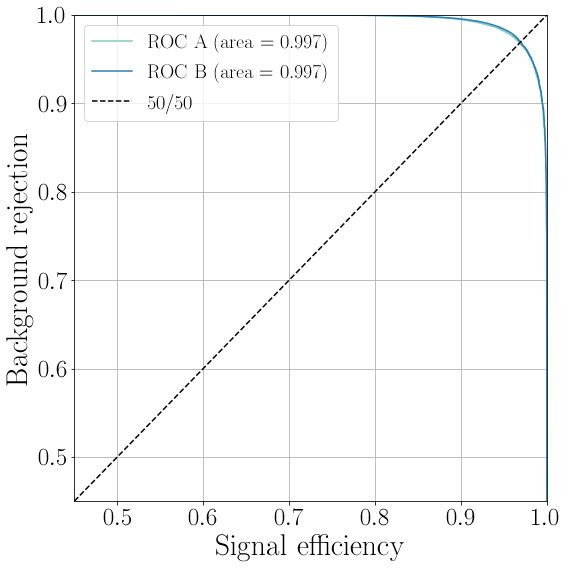

In [15]:
fig, ax = plt.subplots(figsize=(8,8))
plt.plot(tpr_A, 1-fpr_A, lw=1.5, color="#7fcdbb", label='ROC A (area = %0.3f)'%(roc_auc_A))
plt.plot(tpr_B, 1-fpr_B, lw=1.5, color="#2c7fb8", label='ROC B (area = %0.3f)'%(roc_auc_B))

plt.plot([0.45, 1.], [0.45, 1.], linestyle="--", color="k", label='50/50')
plt.xlim(0.45,1.)
plt.ylim(0.45,1.)
plt.ylabel('Background rejection',fontsize=30)
plt.xlabel('Signal efficiency',fontsize=30)
ax.tick_params(axis='both', which='major', labelsize=25)
plt.legend(loc="upper left",fontsize=20)
plt.grid()
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zuds_cc_bb_ROC.pdf")

In [16]:
#Get BDT scores
sig_A, sig_B = train_test_split(df_sig, test_size=0.5, random_state=10)
bkg_A, bkg_B = train_test_split(df_bkg_tot, test_size=0.5, random_state=10)
sig_A_train_vars = sig_A[training_vars]
sig_B_train_vars = sig_B[training_vars]
bkg_A_train_vars = bkg_A[training_vars]
bkg_B_train_vars = bkg_B[training_vars]

sig_A["BDT_all"] = bdt_B.predict_proba(sig_A_train_vars).tolist()
sig_B["BDT_all"] = bdt_A.predict_proba(sig_B_train_vars).tolist()
bkg_A["BDT_all"] = bdt_B.predict_proba(bkg_A_train_vars).tolist()
bkg_B["BDT_all"] = bdt_A.predict_proba(bkg_B_train_vars).tolist()
sig_A['BDT_all'] = sig_A['BDT_all'].apply(lambda x: x[1] if isinstance(x, list) else x)
sig_B['BDT_all'] = sig_B['BDT_all'].apply(lambda x: x[1] if isinstance(x, list) else x)
bkg_A['BDT_all'] = bkg_A['BDT_all'].apply(lambda x: x[1] if isinstance(x, list) else x)
bkg_B['BDT_all'] = bkg_B['BDT_all'].apply(lambda x: x[1] if isinstance(x, list) else x)

/usr/local/bin/start_ipykernel.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/usr/local/bin/start_ipykernel.py:12: SettingWithCopyWarning: 
A value is 

In [17]:
#Combine the samples and plot signal and background BDTs
sig_tot = sig_A.append(sig_B)
bkg_tot = bkg_A.append(bkg_B)

In [18]:
#Find cut which keeps 1 background event i.e. 1e-6 eff
eff_bkg = 1
BDT_cut = 0.
n_bkg_tot = len(bkg_tot)
df_bkg_cut = bkg_tot.copy()
for i in range(0,10000):
    cut = float(i)/10000.
    df_bkg_cut = df_bkg_cut.query(f"BDT_all > {cut}")
    n_bkg_cut = float(len(df_bkg_cut))
    if(n_bkg_cut == 1):
        BDT_cut = cut
        break
print("BDT cut that keeps 10^-6 bkg = %s" % BDT_cut)

#Signal efficiency at this BDT cut
n_sig_pass = float(len(sig_tot.query(f"BDT_all > {BDT_cut}")))
eff_sig_pass = n_sig_pass / len(sig_tot)
print("Signal eff. for this cut = %s" % eff_sig_pass)

BDT cut that keeps 10^-6 bkg = 0.9945
Signal eff. for this cut = 0.653893938403191


In [19]:
#KS tests for signal and background
ks_sig = ks_2samp(sig_A["BDT_all"],sig_B["BDT_all"])

ks_bkg = ks_2samp(bkg_A["BDT_all"],bkg_B["BDT_all"])

print(f"KS score for signal A vs. B: {ks_sig[0]}")
print(f"KS score for background A vs. B: {ks_bkg[0]}")

KS score for signal A vs. B: 0.020597659059700457
KS score for background A vs. B: 0.17203056726513452


findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


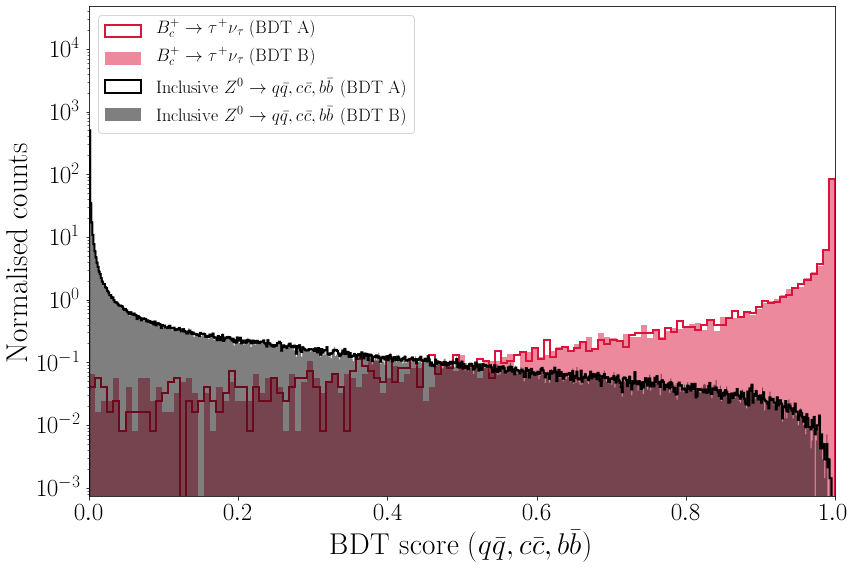

In [20]:
fig, ax = plt.subplots(figsize=(12,8))
xmin = 0
xmax = 1
bins_bkg = int(np.sqrt(len(bkg_A)))
bins_sig = int(np.sqrt(len(sig_A)))
plt.hist(sig_A["BDT_all"],bins=bins_sig,range=(xmin,xmax),density=True,color="crimson",histtype='step',linewidth=2,label="$B_c^+ \\to \\tau^+ \\nu_\\tau$ (BDT A)")
plt.hist(sig_B["BDT_all"],bins=bins_sig,range=(xmin,xmax),density=True,color="crimson",histtype='stepfilled',alpha=0.5,linewidth=2,label="$B_c^+ \\to \\tau^+ \\nu_\\tau$ (BDT B)")
plt.hist(bkg_tot["BDT_all"],bins=bins_bkg,range=(xmin,xmax),density=True,color="k",histtype='step',linewidth=2,label="Inclusive $Z^0 \\to q\\bar{q},c\\bar{c},b\\bar{b}$ (BDT A)")
plt.hist(bkg_B["BDT_all"],bins=bins_bkg,range=(xmin,xmax),density=True,color="k",histtype='stepfilled',alpha=0.5,linewidth=2,label="Inclusive $Z^0 \\to q\\bar{q},c\\bar{c},b\\bar{b}$ (BDT B)")
ax.tick_params(axis='both', which='major', labelsize=25)
plt.xlim(xmin,xmax)
plt.xlabel("BDT score ($q\\bar{q},c\\bar{c},b\\bar{b}$)",fontsize=30)
plt.ylabel("Normalised counts",fontsize=30)
plt.yscale('log')
ymin,ymax = plt.ylim()
plt.ylim(ymin,50*ymax)
plt.legend(fontsize=18, loc="upper left")
plt.tight_layout()
plt.show()
fig.savefig(f"{loc.PLOTS}/Bc2TauNu_vs_inclusive_Zuds_cc_bb_BDT.pdf")

In [21]:
#Save signal sample to ROOT file
df_sig_out = read_root(f"{path}/Bc2TauNu.root","events",columns=training_vars)
df_sig_out["BDT_A"] = bdt_A.predict_proba(df_sig_out).tolist()
df_sig_out["BDT_A"] = df_sig_out["BDT_A"].apply(lambda x: x[1] if isinstance(x, list) else x)
df_sig_out["BDT_B"] = bdt_B.predict_proba(df_sig_out[training_vars]).tolist()
df_sig_out["BDT_B"] = df_sig_out["BDT_B"].apply(lambda x: x[1] if isinstance(x, list) else x)
df_sig_out["BDT_all"] = 0.5*(df_sig_out["BDT_A"] + df_sig_out["BDT_B"])
df_sig_out = df_sig_out.drop("BDT_A",1)
df_sig_out = df_sig_out.drop("BDT_B",1)

root_file_name = f"{path}/Bc2TauNu_all_BDT.root"
if os.path.exists(root_file_name):
    os.remove(root_file_name)
df_sig_out.to_root(root_file_name,"events")

In [23]:
#Save B+ -> tau nu sample to ROOT file
root_file_name = f"{path}/Bu2TauNu_all_BDT.root"
if os.path.exists(root_file_name):
    os.remove(root_file_name)
    
for df_Bu_out in read_root(f"{path}/Bu2TauNu.root","events",columns=training_vars,chunksize=100000):
    df_Bu_out["BDT_A"] = bdt_A.predict_proba(df_Bu_out).tolist()
    df_Bu_out["BDT_A"] = df_Bu_out["BDT_A"].apply(lambda x: x[1] if isinstance(x, list) else x)
    df_Bu_out["BDT_B"] = bdt_B.predict_proba(df_Bu_out[training_vars]).tolist()
    df_Bu_out["BDT_B"] = df_Bu_out["BDT_B"].apply(lambda x: x[1] if isinstance(x, list) else x)
    df_Bu_out["BDT_all"] = 0.5*(df_Bu_out["BDT_A"] + df_Bu_out["BDT_B"])
    df_Bu_out = df_Bu_out.drop("BDT_A",1)
    df_Bu_out = df_Bu_out.drop("BDT_B",1)
    df_Bu_out.to_root(root_file_name,"events",mode='a')

In [24]:
#Also apply MVA to the Z -> qq background samples
for qq in ["uds","cc","bb"]:
    root_file_name = f"{path}/inclusive_Z{qq}_all_BDT.root"
    if os.path.exists(root_file_name):
        os.remove(root_file_name)
        
    for df_qq in read_root(f"{path}/inclusive_Z{qq}.root","events",columns=training_vars,chunksize=100000):
        df_qq["BDT_A"] = bdt_A.predict_proba(df_qq).tolist()
        df_qq["BDT_A"] = df_qq["BDT_A"].apply(lambda x: x[1] if isinstance(x, list) else x)
        df_qq["BDT_B"] = bdt_B.predict_proba(df_qq[training_vars]).tolist()
        df_qq["BDT_B"] = df_qq["BDT_B"].apply(lambda x: x[1] if isinstance(x, list) else x)
        df_qq["BDT_all"] = 0.5*(df_qq["BDT_A"] + df_qq["BDT_B"])
        df_qq = df_qq.drop("BDT_A",1)
        df_qq = df_qq.drop("BDT_B",1)
        df_qq.to_root(root_file_name,"events",mode='a')